<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://assets.vespa.ai/logos/Vespa-logo-green-RGB.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg">
  <img alt="#Vespa" width="200" src="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg" style="margin-bottom: 25px;">
</picture>

# Evaluating a Vespa Application

We are often asked by users and customers what is the best retrieval and ranking strategy for a given use case. And even though we might sometimes have an intuition, we always recommend to set up experiments and do a proper quantitative evaluation.

> Models are temporary; Evals are forever.
> 
> -Eugene Yan


Without a proper evaluation setup, you run the risk of settling for `lgtm@10` (looks good to me @ 10).

Then, if you deploy your application to users, you can be sure that you will get feedback of queries that does not produce relevant results. If you then try to optimize for that without knowing whether your tweaks are actually improving the overall quality of your search, you might end up with a system that is worse than the one you started with. 


![search eval](_static/search-eval.jpg)


## So, what can you do? 

You can set up a proper evaluation pipeline, where you can test different ranking strategies, and see how they perform on a set of evaluation queries that act as a proxy for your real users' queries. This way, you can make informed decisions about what works best for your use case. If you collect real user interactions, it could be even better, but it is important to also keep the evaluation pipeline light enough so that you can run it both during development and in CI pipelines (possibly at different scales).

This guide will show how you easily can evaluate a Vespa application using pyvespa's `VespaEvaluator` class.

We will define and compare 4 different ranking strategies in this guide:

1. `bm25` - Keyword-based retrieval and ranking - The solid baseline.
2. `semantic` - Vector search using cosine similarity (using https://huggingface.co/intfloat/e5-small-v2 for embeddings)
3. `fusion`- Hybrid search (semantic+keyword). Combining BM25 and Semantic with [reciprocal rank fusion](https://docs.vespa.ai/en/phased-ranking.html#cross-hit-normalization-including-reciprocal-rank-fusion)
4. `atan_norm` - Hybrid search, combining BM25 and Semantic with [atan normalization](https://docs.vespa.ai/en/tutorials/hybrid-search.html#hybrid-ranking) as described in Aapo Tanskanen's [Guidebook to the State-of-the-Art Embeddings and Information Retrieval](https://www.linkedin.com/pulse/guidebook-state-of-the-art-embeddings-information-aapo-tanskanen-pc3mf/) (Originally proposed by [Seo et al. (2022)](https://www.mdpi.com/2227-7390/10/8/1335)) 

<div class="alert alert-info">
    Refer to <a href="https://pyvespa.readthedocs.io/en/latest/troubleshooting.html">troubleshooting</a>
    for any problem when running this guide.
</div>


**Pre-requisite**: Create a tenant at [cloud.vespa.ai](https://cloud.vespa.ai/), save the tenant name.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vespa-engine/pyvespa/blob/master/docs/sphinx/source/evaluating-vespa-application-cloud.ipynb)


## Install

Install [pyvespa](https://pyvespa.readthedocs.io/) >= 0.53.0
and the [Vespa CLI](https://docs.vespa.ai/en/vespa-cli.html).
The Vespa CLI is used for data and control plane key management ([Vespa Cloud Security Guide](https://cloud.vespa.ai/en/security/guide)).


In [1]:
#!pip3 install pyvespa vespacli datasets pandas

## Configure application


In [2]:
# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "vespa-team"
# Replace with your application name (does not need to exist yet)
application = "evaluation"
schema_name = "doc"

## Create an application package

The [application package](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.package.ApplicationPackage)
has all the Vespa configuration files -
create one from scratch:


In [3]:
from vespa.package import (
    ApplicationPackage,
    Field,
    Schema,
    Document,
    HNSW,
    RankProfile,
    Component,
    Parameter,
    FieldSet,
    GlobalPhaseRanking,
    Function,
)

package = ApplicationPackage(
    name=application,
    schema=[
        Schema(
            name=schema_name,
            document=Document(
                fields=[
                    Field(name="id", type="string", indexing=["summary"]),
                    Field(
                        name="text",
                        type="string",
                        indexing=["index", "summary"],
                        index="enable-bm25",
                        bolding=True,
                    ),
                    Field(
                        name="embedding",
                        type="tensor<float>(x[384])",
                        indexing=[
                            "input text",
                            "embed",  # uses default model
                            "index",
                            "attribute",
                        ],
                        ann=HNSW(distance_metric="angular"),
                        is_document_field=False,
                    ),
                ]
            ),
            fieldsets=[FieldSet(name="default", fields=["text"])],
            rank_profiles=[
                RankProfile(
                    name="bm25",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[Function(name="bm25text", expression="bm25(text)")],
                    first_phase="bm25text",
                    match_features=["bm25text"],
                ),
                RankProfile(
                    name="semantic",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        )
                    ],
                    first_phase="cos_sim",
                    match_features=["cos_sim"],
                ),
                RankProfile(
                    name="fusion",
                    inherits="bm25",
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        )
                    ],
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    first_phase="cos_sim",
                    global_phase=GlobalPhaseRanking(
                        expression="reciprocal_rank_fusion(bm25text, closeness(field, embedding))",
                        rerank_count=1000,
                    ),
                    match_features=["cos_sim", "bm25text"],
                ),
                RankProfile(
                    name="atan_norm",
                    inherits="bm25",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[
                        Function(
                            name="scale",
                            args=["val"],
                            expression="2*atan(val)/(3.14159)",
                        ),
                        Function(
                            name="normalized_bm25", expression="scale(bm25(text))"
                        ),
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        ),
                    ],
                    first_phase="normalized_bm25",
                    global_phase=GlobalPhaseRanking(
                        expression="normalize_linear(normalized_bm25) + normalize_linear(cos_sim)",
                        rerank_count=1000,
                    ),
                    match_features=["cos_sim", "normalized_bm25"],
                ),
            ],
        )
    ],
    components=[
        Component(
            id="e5",
            type="hugging-face-embedder",
            parameters=[
                Parameter(
                    "transformer-model",
                    {
                        "model-id": "e5-small-v2"
                    },  # in vespa cloud, we can use the model-id for selected models, see https://cloud.vespa.ai/en/model-hub
                ),
                Parameter(
                    "tokenizer-model",
                    {"model-id": "e5-base-v2-vocab"},
                ),
            ],
        )
    ],
)

Note that the name cannot have `-` or `_`.


## Deploy to Vespa Cloud

The app is now defined and ready to deploy to Vespa Cloud.

Deploy `package` to Vespa Cloud, by creating an instance of
[VespaCloud](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.deployment.VespaCloud):


In [4]:
from vespa.deployment import VespaCloud
import os

# Key is only used for CI/CD. Can be removed if logging in interactively

vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=application,
    key_content=os.getenv(
        "VESPA_TEAM_API_KEY", None
    ),  # Key is only used for CI/CD. Can be removed if logging in interactively
    application_package=package,
)

Setting application...
Running: vespa config set application vespa-team.evaluation
Setting target cloud...
Running: vespa config set target cloud

Api-key found for control plane access. Using api-key.


For more details on different authentication options and methods, see [authenticating-to-vespa-cloud](https://pyvespa.readthedocs.io/en/latest/authenticating-to-vespa-cloud.html).

The following will upload the application package to Vespa Cloud Dev Zone (`aws-us-east-1c`), read more about [Vespa Zones](https://cloud.vespa.ai/en/reference/zones.html).
The Vespa Cloud Dev Zone is considered as a sandbox environment where resources are down-scaled and idle deployments are expired automatically.
For information about production deployments, see the following [method](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.deployment.VespaCloud.deploy_to_prod).

> Note: Deployments to dev and perf expire after 7 days of inactivity, i.e., 7 days after running deploy. This applies to all plans, not only the Free Trial. Use the Vespa Console to extend the expiry period, or redeploy the application to add 7 more days.


Now deploy the app to Vespa Cloud dev zone.

The first deployment typically takes 2 minutes until the endpoint is up. (Applications that for example refer to large onnx-models may take a bit longer.)


In [5]:
from vespa.application import Vespa

app: Vespa = vespa_cloud.deploy()

Deployment started in run 3 of dev-aws-us-east-1c for vespa-team.evaluation. This may take a few minutes the first time.
INFO    [13:27:49]  Deploying platform version 8.478.26 and application dev build 3 for dev-aws-us-east-1c of default ...
INFO    [13:27:49]  Using CA signed certificate version 1
INFO    [13:27:49]  Using 1 nodes in container cluster 'evaluation_container'
INFO    [13:27:52]  Session 338110 for tenant 'vespa-team' prepared and activated.
INFO    [13:27:52]  ######## Details for all nodes ########
INFO    [13:27:52]  h113421f.dev.us-east-1c.aws.vespa-cloud.net: expected to be UP
INFO    [13:27:52]  --- platform vespa/cloud-tenant-rhel8:8.478.26
INFO    [13:27:52]  --- container-clustercontroller on port 19050 has config generation 338110, wanted is 338110
INFO    [13:27:52]  --- metricsproxy-container on port 19092 has config generation 338110, wanted is 338110
INFO    [13:27:52]  h113421e.dev.us-east-1c.aws.vespa-cloud.net: expected to be UP
INFO    [13:27:52]  --- 

If the deployment failed, it is possible you forgot to add the key in the Vespa Cloud Console in the `vespa auth api-key` step above.

If you can authenticate, you should see lines like the following

```
 Deployment started in run 1 of dev-aws-us-east-1c for mytenant.hybridsearch.
```

The deployment takes a few minutes the first time while Vespa Cloud sets up the resources for your Vespa application

`app` now holds a reference to a [Vespa](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.application.Vespa) instance. We can access the
mTLS protected endpoint name using the control-plane (vespa_cloud) instance. This endpoint we can query and feed to (data plane access) using the
mTLS certificate generated in previous steps.

See [Authenticating to Vespa Cloud](https://pyvespa.readthedocs.io/en/latest/authenticating-to-vespa-cloud.html) for details on using token authentication instead of mTLS.


## Getting your evaluation data

For evaluating information retrieval methods, in addition to the document corpus, we also need a set of queries and a mapping from queries to relevant documents.

For this guide, we will use the [NanoMSMARCO](https://huggingface.co/datasets/zeta-alpha-ai/NanoMSMARCO) dataset, made available on huggingface by [Zeta Alpha](https://zeta-alpha.com/).

This dataset is a subset of their 🍺[NanoBEIR](https://huggingface.co/collections/zeta-alpha-ai/nanobeir-66e1a0af21dfd93e620cd9f6)-collection, with 50 queries and up to 10K documents each. 

This is a great dataset for testing and evaluating information retrieval methods quickly, as it is small and easy to work with. 

Note that for almost any real-world use case, we would recommend you to create your own evaluation dataset. See [Vespa blog post](https://blog.vespa.ai/improving-retrieval-with-llm-as-a-judge/) on how you can get help from an LLM for this. 

Note that creating 20-50 queries and annotating relevant documents for each query can be a good start and well worth the effort.


In [6]:
from datasets import load_dataset

dataset_id = "zeta-alpha-ai/NanoMSMARCO"

dataset = load_dataset(dataset_id, "corpus", split="train", streaming=True)
vespa_feed = dataset.map(
    lambda x: {
        "id": x["_id"],
        "fields": {"text": x["text"], "id": x["_id"]},
    }
)

Note that we are only _evaluating_ rank strategies here, we consider it OK to use the `train` split for evaluation. If we were to make changes to our ranking strategies, such as adding weighting terms, or training ml models for ranking, we would suggest to adopt a `train`, `validation`, `test` split approach to avoid overfitting.

In [7]:
query_ds = load_dataset(dataset_id, "queries", split="train")
qrels = load_dataset(dataset_id, "qrels", split="train")

In [8]:
ids_to_query = dict(zip(query_ds["_id"], query_ds["text"]))

Let us print the first 5 queries:

In [9]:
for idx, (qid, q) in enumerate(ids_to_query.items()):
    print(f"qid: {qid}, query: {q}")
    if idx == 5:
        break

qid: 994479, query: which health care system provides all citizens or residents with equal access to health care services
qid: 1009388, query: what's right in health care
qid: 1088332, query: weather in oran
qid: 265729, query: how long keep financial records
qid: 1099433, query: how do hoa fees work
qid: 200600, query: heels or heal


In [10]:
relevant_docs = dict(zip(qrels["query-id"], qrels["corpus-id"]))

Let us print the first 5 query ids and their relevant documents:

In [11]:
for idx, (qid, doc_id) in enumerate(relevant_docs.items()):
    print(f"qid: {qid}, doc_id: {doc_id}")
    if idx == 5:
        break

qid: 994479, doc_id: 7275120
qid: 1009388, doc_id: 7248824
qid: 1088332, doc_id: 7094398
qid: 265729, doc_id: 7369987
qid: 1099433, doc_id: 7255675
qid: 200600, doc_id: 7929603


We can see that this dataset only has one relevant document per query.
The `VespaEvaluator` class handles this just fine, but you could also provide a set of relevant documents per query if there are multiple relevant docs.

```python
# multiple relevant docs per query
qrels = {
    "q1": {"doc1", "doc2"},
    "q2": {"doc3", "doc4"},
    # etc. 
}
```

Now we can feed to Vespa using `feed_iterable` which accepts any `Iterable` and an optional callback function where we can
check the outcome of each operation. The application is configured to use [embedding](https://docs.vespa.ai/en/embedding.html)
functionality, that produce a vector embedding using a concatenation of the title and the body input fields. This step may be resource intensive, depending on the model size.

Read more about embedding inference in Vespa in the [Accelerating Transformer-based Embedding Retrieval with Vespa](https://blog.vespa.ai/accelerating-transformer-based-embedding-retrieval-with-vespa/)
blog post.

Default node resources in Vespa Cloud have 2 v-cpu for the Dev Zone.


In [ ]:
from vespa.io import VespaResponse


def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print(f"Error when feeding document {id}: {response.get_json()}")


app.feed_async_iterable(
    vespa_feed, schema="doc", namespace="tutorial", callback=callback
)

## VespaEvaluator

The `VespaEvaluator` class is a high-level API that allows you to evaluate a Vespa application using a set of queries and a mapping from queries to relevant documents. It is inspired by [SentenceTransformers](https://www.sbert.net/) [`InformationRetrievalEvaluator`](https://sbert.net/docs/package_reference/sentence_transformer/evaluation.html#informationretrievalevaluator) class.

The difference it that `VespaEvaluator` works on a retrieval and ranking _system_ (Vespa application) instead of a single model. Your application should be fed with the document corpus in advance, instead of taking in the document corpus. 

Let us take a look at its API and documentation:

In [13]:
from vespa.evaluation import VespaEvaluator

?VespaEvaluator

Init signature:
VespaEvaluator(
    queries: 'Dict[str, str]',
    relevant_docs: 'Union[Dict[str, Set[str]], Dict[str, str]]',
    vespa_query_fn: 'Callable[[str, int], dict]',
    app: 'Vespa',
    name: 'str' = '',
    accuracy_at_k: 'List[int]' = [1, 3, 5, 10],
    precision_recall_at_k: 'List[int]' = [1, 3, 5, 10],
    mrr_at_k: 'List[int]' = [10],
    ndcg_at_k: 'List[int]' = [10],
    map_at_k: 'List[int]' = [100],
    write_csv: 'bool' = False,
    csv_dir: 'Optional[str]' = None,
)
Docstring:     
Evaluate retrieval performance on a Vespa application.

This class:

- Iterates over queries and issues them against your Vespa application.
- Retrieves top-k documents per query (with k = max of your IR metrics).
- Compares the retrieved documents with a set of relevant document ids.
- Computes IR metrics: Accuracy@k, Precision@k, Recall@k, MRR@k, NDCG@k, MAP@k.
- Logs vespa search times for each query.
- Logs/returns these metrics.
- Optionally writes out to CSV.

Example usage::



We now have created the app, the queries, and the relevant documents. The only thing missing before we can initialize the `VespaEvaluator` is the ranking strategies we want to evaluate. Each of them is passed as `vespa_query_fn`. 

We will use the `vespa.querybuilder` module to create the queries. See [reference doc](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa-querybuilder) and [example notebook](https://pyvespa.readthedocs.io/en/latest/query.html#Using-the-Querybuilder-DSL-API) for more details on usage. 

This module is a Python wrapper around the Vespa Query Language (YQL), which is an alternative to providing the YQL query as a string directly.

In [ ]:
import vespa.querybuilder as qb


def semantic_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_(schema_name)
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "semantic",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }


def bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();",  # provide the yql directly as a string
        "query": query_text,
        "ranking": "bm25",
        "hits": top_k,
    }


def fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_(schema_name)
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "fusion",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }


def atan_norm_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_(schema_name)
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "atan_norm",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }

## Run a test query

Great, now we have deployed the application and fed the data. Let us run a test query to see if everything is working as expected.

In [21]:
from vespa.io import VespaQueryResponse

response: VespaQueryResponse = app.query(
    body=atan_norm_query_fn("how to bake a cake", 3)
)

In [22]:
response.get_json()

{'timing': {'querytime': 0.047,
  'summaryfetchtime': 0.006,
  'searchtime': 0.054},
 'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 1911},
  'coverage': {'coverage': 100,
   'documents': 5043,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'id:tutorial:doc::1365411',
    'relevance': 1.9456390778613541,
    'source': 'evaluation_content',
    'fields': {'matchfeatures': {'cos_sim': 0.6327433624922647,
      'normalized_bm25': 0.9258608662490951},
     'sddocname': 'doc',
     'text': 'Cooked. 1  Beef: 2 <hi>to</hi> 3 months. 2  Breads and <hi>cakes</hi>: 3 months. 3  Casseroles: 3 months.  Chicken pieces: 4 1  months. Hard sausage (pepperoni): 1 <hi>to</hi> 2 months.  Vegetable or meat soups and stews: 2 <hi>to</hi> 3 months.',
     'documentid': 'id:tutorial:doc::1365411',
     'id': '1365411'}},
   {'id': 'id:tutorial:doc::5144958',
    'relevance': 1.9291632118657427,
    'source': 'evaluation_content',
    'f

In [23]:
all_results = {}
for evaluator_name, query_fn in [
    ("semantic", semantic_query_fn),
    ("bm25", bm25_query_fn),
    ("fusion", fusion_query_fn),
    ("atan_norm", atan_norm_query_fn),
]:
    print(f"Evaluating {evaluator_name}...")
    evaluator = VespaEvaluator(
        queries=ids_to_query,
        relevant_docs=relevant_docs,
        vespa_query_fn=query_fn,
        app=app,
        name=evaluator_name,
        write_csv=True,  # optionally write metrics to CSV
    )

    results = evaluator.run()
    all_results[evaluator_name] = results

Evaluating semantic...
Evaluating bm25...
Evaluating fusion...
Evaluating atan_norm...


### Looking at the results

In [24]:
import pandas as pd

results = pd.DataFrame(all_results)

In [25]:
# take out all rows with "searchtime" to a separate dataframe
searchtime = results[results.index.str.contains("searchtime")]
results = results[~results.index.str.contains("searchtime")]


# Highlight the maximum value in each row
def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: lightgreen; color: black;" if v else "" for v in is_max]


# Style the DataFrame: Highlight max values and format numbers to 4 decimals
styled_df = results.style.apply(highlight_max, axis=1).format("{:.4f}")
styled_df

,semantic,bm25,fusion,atan_norm
accuracy@1,0.3800,0.3000,0.4400,0.4400
accuracy@3,0.6400,0.6000,0.6800,0.7000
accuracy@5,0.7200,0.6600,0.7200,0.7400
accuracy@10,0.8200,0.7400,0.8000,0.8400
precision@1,0.3800,0.3000,0.4400,0.4400
recall@1,0.3800,0.3000,0.4400,0.4400
precision@3,0.2133,0.2000,0.2267,0.2333
recall@3,0.6400,0.6000,0.6800,0.7000
precision@5,0.1440,0.1320,0.1440,0.1480
recall@5,0.7200,0.6600,0.7200,0.7400


We can see that for this particular dataset, the hybrid strategy `atan_norm` is the best across all metrics.

<Axes: >

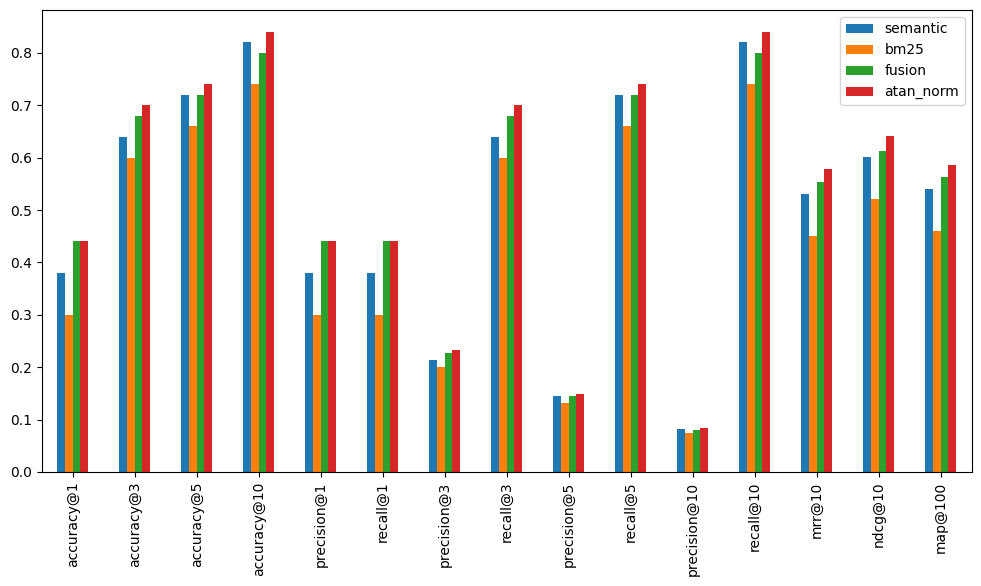

In [26]:
results.plot(kind="bar", figsize=(12, 6))

### Looking at searchtimes

Ranking quality is not the only thing that matters. For many applications, search time is equally important. 



[Text(0, 0.5, 'time (ms)')]

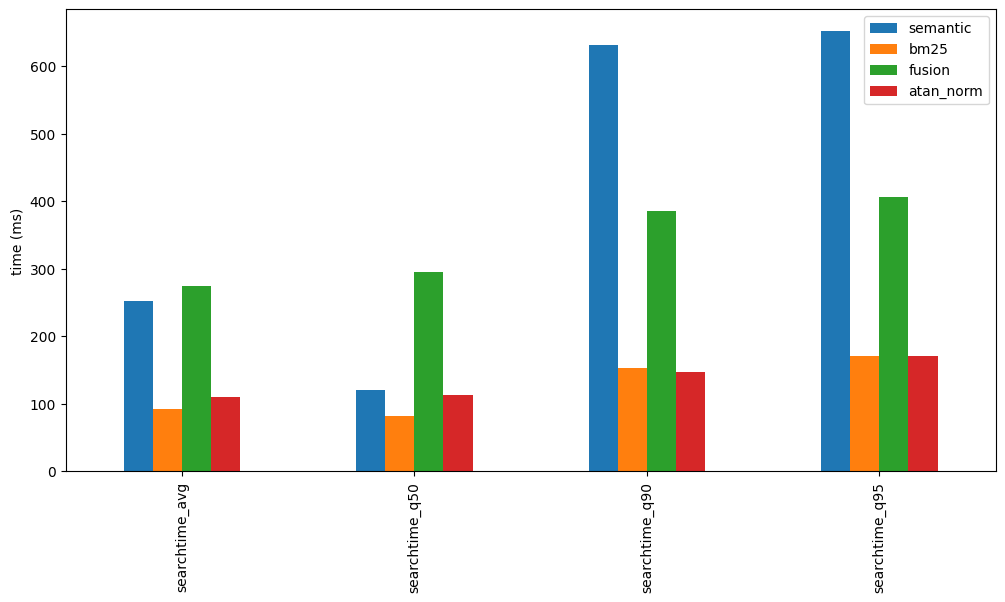

In [27]:
# plot search time, add (ms) to the y-axis
# convert to ms
searchtime = searchtime * 1000
searchtime.plot(kind="bar", figsize=(12, 6)).set(ylabel="time (ms)")

We can see that both hybrid strategies, `fusion` and `atan_norm` strategy is a bit slower on average than pure `bm25` or `semantic`, as expected. 

Depending on the latency budget of your application, this is likely still an attractive trade-off.

## Conclusion and next steps

We have shown how you can evaluate a Vespa application using pyvespa's `VespaEvaluator` class. We have defined and compared 4 different ranking strategies in terms of both ranking quality and searchtime latency.

We hope this can provide you with a good starting point for evaluating your own Vespa application. 

If you are ready to advance, you can try to optimize the ranking strategies further, by for example weighing each of the terms in the `atan_norm` strategy differently (`a * normalize_linear(normalized_bm25) + (1-a) * normalize_linear(cos_sim)`) , or by adding a [crossencoder](https://pyvespa.readthedocs.io/en/latest/examples/cross-encoders-for-global-reranking.html) for re-ranking the top-k results.


## Cleanup

In [ ]:
vespa_cloud.delete()

Deactivated vespa-team.evaluation in dev.aws-us-east-1c
Deleted instance vespa-team.evaluation.default
